In [1]:
import json
from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import datetime as dt

mpl.rcParams['savefig.dpi'] = 100 
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 40})

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Analyzing Rent Prices vs. Taxi Trips

In [2]:
# taxi id - zillow id mapping
tz_map = json.load(open('./taxi_zillow_mapping.json'))
tz_map[4]

{u'id': 5,
 u'name': u'Prospect Park',
 u'taxi_ids': [190],
 u'zillow_ids': [403161]}

In [3]:
# Load the yellow taxi analysis
yellow = pd.read_csv('./yellow_daily.csv', index_col=None, header=None)
yellow.columns = ['location_id', 'event', 'year', 'month', 'day',
                 'passengers', 'distance', 'fare', 'count']
yellow[:10]

,location_id,event,year,month,day,passengers,distance,fare,count
0,1,DO,2013,1,1,1934,15863.27,78576.59,958
1,1,DO,2013,1,2,1692,14440.40,71460.05,872
2,1,DO,2013,1,3,1167,9807.88,47847.31,580
3,1,DO,2013,1,4,910,7760.85,39264.87,457
4,1,DO,2013,1,5,1028,9029.48,44363.66,526
5,1,DO,2013,1,6,962,8768.42,43650.40,514
6,1,DO,2013,1,7,670,6853.39,34790.31,412
7,1,DO,2013,1,8,598,5988.66,31528.43,378
8,1,DO,2013,1,9,700,6609.62,34114.78,399
9,1,DO,2013,1,10,715,7452.30,39019.75,447


In [94]:
# What are daily stats for the entire city?
yellow_citywide = yellow.drop(['location_id', 'composite_id'], axis=1)\
    .groupby(by=['event', 'year', 'month', 'day'])\
    .sum().reset_index()
yellow_citywide = yellow_citywide[yellow_citywide['year'] >= 2013]
yellow_citywide[:20]

,event,year,month,day,passengers,distance,fare,count
9,DO,2013,1,1,737400,1334623.13,5880041.36,401522
10,DO,2013,1,2,658743,1153151.10,5422178.91,384498
11,DO,2013,1,3,731265,1191798.40,5863573.06,430886
12,DO,2013,1,4,795706,1235170.54,6205018.53,465817
13,DO,2013,1,5,824487,1270636.13,6072842.87,462717
14,DO,2013,1,6,697474,1218320.90,5561957.18,398122
15,DO,2013,1,7,653631,1125166.10,5516381.09,397818
16,DO,2013,1,8,710250,1160534.35,5893047.37,432226
17,DO,2013,1,9,737252,1197241.63,6120219.03,446699
18,DO,2013,1,10,786511,1294099.64,6663054.63,475660


# Adjust Zillow Rent Prices With Inflation

In [22]:
# Load zillow rent prices
# DL from: http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_MedianRentalPrice_1Bedroom.csv
zillow = pd.read_csv('./Neighborhood_MedianRentalPrice_1Bedroom.csv')
z = zillow
zillow = zillow[(z['City'] == 'New York') & (z['State'] == 'NY')]
early_cols = ['{}-{:02}'.format(year, month) for year in [2010, 2011, 2012, 2017] for month in range(1,13)]
early_cols = [c for c in early_cols if c in zillow.columns]
zillow = zillow.drop(early_cols, axis=1)
zillow.describe()

,SizeRank,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,...,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
count,90.000000,85.000000,86.000000,86.000000,86.000000,86.000000,86.000000,87.000000,87.000000,88.000000,...,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,93.744444,2016.076471,2036.447674,2048.325581,2057.912791,2078.302326,2094.284884,2087.545977,2114.068966,2122.255682,...,2269.927778,2268.516667,2266.350000,2275.455556,2265.605556,2266.338889,2284.277778,2289.950000,2274.866667,2243.255556
std,66.771043,846.657671,830.859817,831.371025,823.442373,831.024832,837.656621,838.071740,834.468307,845.200959,...,832.719872,823.898960,830.618858,829.243122,807.190347,809.049650,803.364380,803.575685,795.287047,788.903852
min,3.000000,975.000000,1000.000000,1050.000000,1050.000000,1012.500000,1040.000000,1050.000000,1050.000000,1050.000000,...,1300.000000,1300.000000,1275.000000,1300.000000,1300.000000,1300.000000,1325.000000,1300.000000,1350.000000,1349.000000
25%,37.500000,1300.000000,1350.000000,1350.000000,1356.250000,1358.125000,1375.000000,1375.000000,1395.000000,1390.625000,...,1599.250000,1600.000000,1595.125000,1596.250000,1600.000000,1600.000000,1606.250000,1600.000000,1631.250000,1600.000000
50%,79.500000,1575.000000,1612.500000,1600.000000,1600.000000,1650.000000,1688.250000,1700.000000,1750.000000,1756.000000,...,1925.750000,1950.000000,1900.000000,1912.500000,1925.000000,1950.000000,1925.000000,2022.500000,1937.500000,1886.250000
75%,137.500000,2800.000000,2875.000000,2871.250000,2875.000000,2868.500000,2905.000000,2910.000000,2925.000000,2925.000000,...,2950.000000,2898.750000,2900.000000,2999.375000,2926.250000,2887.500000,2983.750000,2998.750000,2943.750000,2860.750000
max,262.000000,3895.000000,3795.000000,3825.000000,3895.000000,3895.000000,3995.000000,4025.000000,4012.500000,3995.000000,...,4450.000000,4450.000000,4397.500000,4295.000000,4295.000000,4295.000000,4295.000000,4206.000000,4250.000000,4212.000000


In [23]:
zillow_cols_to_idx = {z: i + 1 for i, z in enumerate(zillow.columns)}
zillow[:3]

,RegionName,City,State,Metro,CountyName,SizeRank,2013-01,2013-02,2013-03,2013-04,...,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
2,Upper West Side,New York,NY,New York,New York,3,3000.0,2990.0,3000.0,3000.0,...,3260.5,3250.0,3295.0,3225.0,3070.0,3200.0,3239.0,3250.0,3226.0,3180.0
4,Upper East Side,New York,NY,New York,New York,5,2545.0,2500.0,2500.0,2500.0,...,2800.0,2800.0,2795.0,2700.0,2695.0,2700.0,2725.0,2700.0,2695.0,2700.0
5,East New York,New York,NY,New York,Kings,6,1125.0,1175.0,1200.0,1200.0,...,1400.0,1450.0,1500.0,1500.0,1400.0,1350.0,1425.0,1350.0,1500.0,1550.0


In [24]:
# Inflation data
inflation = pd.read_csv('cpi_inflation.csv', index_col='Year')
print(inflation.ix[2015]['Jul'])
inflation

238.212


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2013,225.060,225.584,225.745,226.309,227.011,227.330,227.555,227.909,228.343,228.576,229.120,229.626
2014,230.545,231.141,232.096,232.040,232.849,233.092,233.610,233.899,234.177,234.616,235.004,235.456
2015,235.791,236.295,236.586,237.171,237.285,237.768,238.212,238.635,239.133,239.535,239.989,240.303
2016,240.752,241.310,241.641,242.202,242.919,243.459,244.048,244.804,245.595,246.380,246.947,247.616


In [25]:
# Create an array with zillow prices adjusted by inflation.
zillow_inf_adjust = zillow.copy()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
standard = inflation.ix[2016]['Dec']
for year in range(2013, 2017):
    for month in range(1, 13):
        colname = '{}-{:02}'.format(year, month)
        col = zillow_inf_adjust[colname]
        col = standard / inflation.ix[year][months[month - 1]] * col
        zillow_inf_adjust[colname] = col

In [26]:
zillow.to_csv('zillow_ny.csv')
zillow_inf_adjust.to_csv('zillow_inf_adjust.csv')

In [27]:
len(zillow_inf_adjust)

90

In [28]:
# What is the Zillow Neighborhood ID?
zillow_shape = json.load(open('ZillowNeighborhoods-NY_mapshaper.json'))

In [29]:
# Need a mapping from zillow region name to zillow ID
z_name_to_id = {}
for z in zillow_shape['features']:
    prop = z['properties']
    zid = int(prop['RegionID'])
    z_name_to_id[prop['Name']] = prop['RegionID']
    
region_ids = []
for z in zillow_inf_adjust.itertuples():
    regid = z_name_to_id[z.RegionName]
    region_ids.append(regid)
    print(z.RegionName, regid)

Upper West Side 270958
Upper East Side 270957
East New York 194430
Washington Heights 198687
Astoria 272816
Williamsburg 199001
Bedford Stuyvesant 272902
Flatbush 194737
Crown Heights 403222
Jamaica 25294
Harlem 195267
Williamsbridge 343222
East Harlem 270828
Bushwick 193587
East Flatbush 194379
Corona 10957
Sunset Park 270945
Concourse 270817
Elmhurst 403223
Bensonhurst 193285
Soundview 343205
Lower East Side 270875
Flushing 18131
Murray Hill 274627
Sheepshead Bay 403131
Gravesend 403215
Forest Hills 273757
East Village 270829
Jackson Heights 274117
Midwood 270886
Park Slope 197044
Gramercy 273860
Bay Ridge 193189
Tremont 343215
Kensington 403217
Bath Beach 193182
University Heights 343213
Bayside 37309
Bedford Park 343221
Hamilton Heights 270850
Chelsea 276254
Woodside 199091
Fordham 343214
Sunnyside 275620
Greenwich Village 195133
Rego Park 6719
Kew Gardens Hills 57348
Parkchester 343211
Ocean Parkway 270903
Inwood 195576
Norwood 403213
Morris Park 343212
Fort Greene 273766
Greenwoo

In [58]:
zillow_inf_adjust['RegionId'] = region_ids
zillow_inf_adjust.to_csv('zillow_inf_adjust.csv')
zillow_inf_adjust[:5]

,RegionName,City,State,Metro,CountyName,SizeRank,2013-01,2013-02,2013-03,2013-04,...,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,RegionId,CompositeId
2,Upper West Side,New York,NY,New York,New York,3,3300.666489,3282.022838,3290.650956,3282.450101,...,3358.711011,3280.066048,3114.883629,3236.757569,3265.653714,3266.304083,3234.739503,3180.0,270958,-1
4,Upper East Side,New York,NY,New York,New York,5,2800.065405,2744.166253,2742.209130,2735.375085,...,2849.043179,2746.101808,2734.401101,2731.014199,2747.424011,2713.544931,2702.300980,2700.0,270957,-1
5,East New York,New York,NY,New York,Kings,6,1237.749933,1289.758139,1316.260382,1312.980041,...,1529.003495,1525.612115,1420.468105,1365.507100,1436.726318,1356.772465,1504.063625,1550.0,194430,-1
9,Washington Heights,New York,NY,New York,New York,10,1540.311028,1536.733102,1590.481295,1586.517549,...,1630.937061,1627.319590,1623.392120,1663.895688,1613.166392,1603.001542,1599.320988,1600.0,198687,-1
11,Astoria,New York,NY,New York,Queens,12,2035.411002,2003.241365,2001.812665,1996.823812,...,1987.704543,1983.295750,2029.240149,2022.973481,2016.457990,2085.409530,2105.689075,2000.0,272816,-1


In [43]:
# Group zillow and taxi data according to composite ID.
taxi_to_cluster = {}
zillow_to_cluster = {}
for cluster in tz_map:
    for t in cluster['taxi_ids']:
        assert t not in taxi_to_cluster
        taxi_to_cluster[t] = cluster['id']
    for z in cluster['zillow_ids']:
        assert z not in zillow_to_cluster
        zillow_to_cluster[z] = cluster['id']

In [64]:
yellow['composite_id'] = yellow['location_id'].map(lambda x: taxi_to_cluster.get(x, -1))
zillow_inf_adjust['CompositeId'] = zillow_inf_adjust['RegionId'].map(lambda x: zillow_to_cluster.get(int(x), -1))

In [66]:
yellow_composite = yellow.drop('location_id', axis=1)\
    .groupby(by=['composite_id', 'event', 'year', 'month', 'day'])\
    .sum().reset_index()

In [70]:
z = zillow_inf_adjust
zillow_composite = z.drop(['RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'RegionId'], axis=1)\
    .groupby(by=['CompositeId'])\
    .mean().reset_index()

In [72]:
zillow_composite[:10]

,CompositeId,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,...,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
0,-1,1877.941704,1860.544719,1877.042149,1847.609101,1844.213505,1848.977962,1861.839889,1899.962178,1908.279457,...,1959.789936,1958.701018,1977.511187,1975.667689,1968.362945,1949.640692,1933.909241,1957.018654,1947.135701,1944.75
1,2,3410.688705,3292.999504,3499.058850,3391.865105,3381.376233,3360.837408,3264.476720,3259.406166,3361.651551,...,3214.567859,3271.530375,3261.874123,3254.639179,3221.418737,3236.757569,3226.332784,3152.737203,3208.669067,3200.00
2,9,2200.444326,2085.566352,1974.390573,2188.300068,2399.686359,2396.319008,2475.561513,2824.818678,2711.009315,...,2472.153318,2555.883106,2497.372375,2541.669784,2536.550187,2478.142514,2520.572487,2511.034077,2506.772708,2300.00
3,16,2668.038745,2634.399603,2413.144034,2461.837576,2508.763011,2505.242599,2502.765485,2716.171805,2656.789129,...,2510.580572,2530.324275,2510.114071,2542.686859,2485.819183,2478.142514,2419.749588,2512.541602,2406.501800,2400.00
4,18,NaN,NaN,NaN,NaN,NaN,NaN,1441.810551,1521.056211,1626.605589,...,1690.799161,1635.765188,1630.937061,1627.319590,1623.392120,1714.470025,1663.577842,1758.779122,1704.605442,1650.00
5,19,2860.577624,2853.932903,2906.741678,2899.497590,2917.800459,2935.490784,2829.213157,2824.818678,2922.468041,...,2966.583982,2959.712637,2950.976745,2944.431383,2937.325116,2882.737210,2823.041186,2814.046595,2807.585433,2800.00
6,20,1705.344353,1750.778069,1700.169660,1745.169304,1745.226443,1797.239256,1795.462196,1841.564484,1840.775325,...,1865.002711,1865.794667,1834.804194,1830.734538,1826.316135,1770.101796,1814.812191,1741.191330,1804.876350,1712.50
7,21,2862.778068,2881.374566,3043.852134,3018.759943,3025.786345,3049.860555,3046.844939,3014.950704,2982.110246,...,2997.325785,2949.489104,2956.073424,2949.516756,2917.032715,2933.311547,2898.658360,2882.387726,2902.842796,2785.00
8,22,1320.266596,1372.083126,1343.682474,1367.687542,1412.542652,1416.006686,1414.606579,1412.409339,1404.302825,...,1485.853808,1482.412201,1523.906817,1423.904641,1521.930112,1466.655774,1512.343492,1502.499878,1504.063625,1525.00
9,24,1581.569359,1619.058089,1590.481295,1624.812800,1636.149790,1661.084767,1632.238360,1684.026519,1735.045962,...,1841.946358,1835.124070,1824.610837,1830.734538,1877.047138,1845.963301,1814.812191,1809.029954,1804.876350,1800.00


# Generate Plots

In [86]:
# What neighborhoods are available?
for c in tz_map:
    print(c['name'])

Melrose South
Central Park
Ridgewood
Ocean Hill
Prospect Park
Brownsville
Highbridge
Bronx Park
Greenpoint
Laurelton
Howard Beach
Canarsie
Van Cortlandt Park-Woodlawn/Wakefield
Morningside Heights
Coney Island
Park Slope
Belmont
Bayside-Douglaston-Oakland Gardens
East Village
East Elmhurst-Jackson Heights
Long Island City/Hunters Point
East Flatbush
Randalls Island
Kew Gardens-Richmond Hill
JFK Airport
Kingsbridge Heights-University Heights/Morris Heights
East Harlem
Hunts Point-Longwood
Bellerose-Glen Oaks
Flatlands-Midwood
Cobble Hill
Rosedale-Springfield Gardens South
Mott Haven/Port Morris
Dyker Heights
Pelham Bay Park
Marble Hill
Bay Ridge
Rikers Island
Grymes Hill/Clifton
Cambria Heights-Queens Village
Concourse
Forest Hills-Forest Park/Highland Park-Glendale
College Point
LaGuardia Airport
Hamilton Heights-Manhattanville
Pelham Bay-Schuylerville/Edgewater Park
Boerum Hill-Carroll Gardens-Gowanus
TriBeCa/Civic Center
Brooklyn Heights
Hollis-Saint Albans-Springfield Gardens North


In [149]:
name = 'Sunnyside'
# find cluster matching that name.
cluster = None
for c in tz_map:
    if name.lower() in c['name'].lower():
        cluster = c
print(cluster)
name = cluster['name']

{u'zillow_ids': [270802, 275620], u'id': 111, u'name': u'Sunnyside', u'taxi_ids': [226]}


In [150]:
# Get taxi dropoffs
event = 'DO'
yc = yellow_composite
taxis = yc[yc['composite_id'] == cluster['id']]
taxis = taxis[taxis['event'] == event]
taxis = taxis[taxis['year'] < 2017]
taxis = taxis[taxis['year'] >= 2013]
taxis = taxis[['year', 'month', 'count']]
print(len(taxis))

cw = yellow_citywide
cw = cw[cw['event'] == event]
cw = cw[cw['year'] < 2017]
cw = cw[cw['year'] >= 2013]
cw = cw['count']
print(len(cw))

avg_cw = cw.mean()

taxis['proportion'] = taxis['count'].as_matrix() * avg_cw / cw.as_matrix()
taxis = taxis.drop('count', axis=1).groupby(by=['year', 'month']).mean()
taxis

1461
1461


proportion
year month             
2013 1      1228.234390
     2      1168.895255
     3      1240.145035
     4      1125.450680
     5      1189.837663
     6      1214.563635
     7      1199.277559
     8      1225.173581
     9      1174.027951
     10     1155.316864
     11     1187.188206
     12     1255.383038
2014 1      1135.926323
     2      1142.212003
     3      1182.105625
     4      1127.012537
     5      1178.005684
     6      1206.467226
     7      1171.124246
     8      1179.464975
     9      1162.917726
     10     1144.923640
     11     1221.265249
     12     1223.396654
2015 1      1181.149973
     2      1238.665883
     3      1300.090567
     4      1178.594525
     5      1182.474189
     6      1161.070497
     7      1183.614416
     8      1214.442749
     9      1195.097580
     10     1148.920132
     11     1191.704093
     12     1204.956141
2016 1      1205.489449
     2      1095.022038
     3      1195.456717
     4      1233.897747
     5      1172.330707
     6      1156.606799
     7      1189.307363
     8      1164.428485
     9      1150.452460
     10     1132.316121
     11     1116.811311
     12     1186.654726

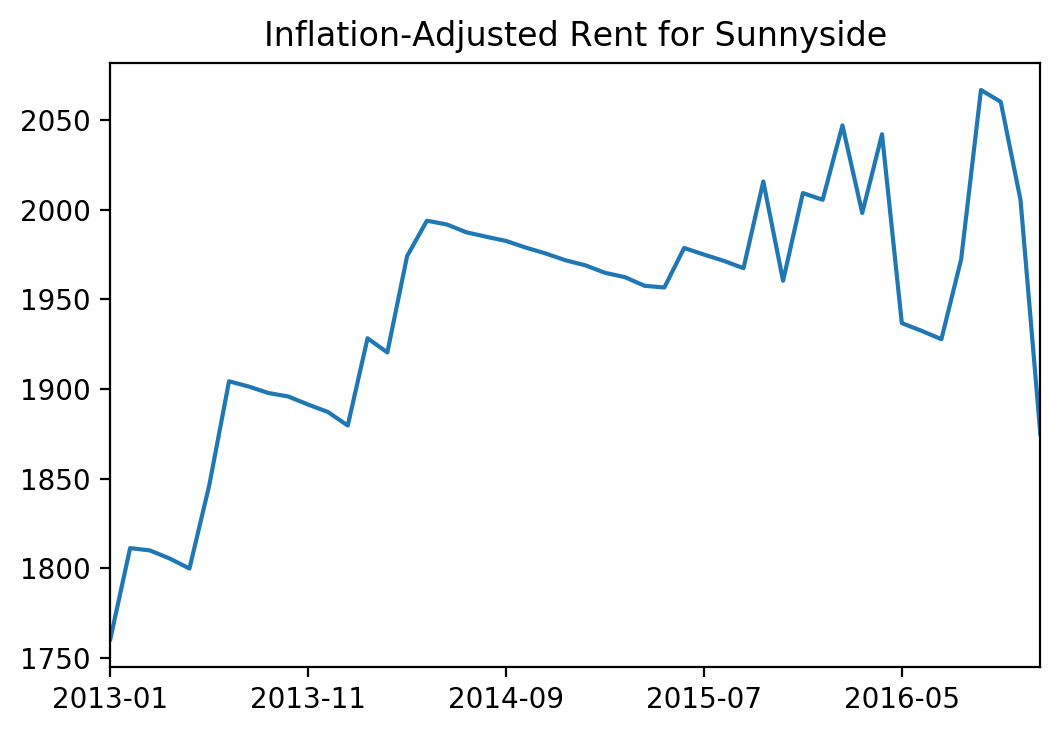

In [151]:
# Get one of the areas' columns
z = zillow_composite
loc = z[z['CompositeId'] == cluster['id']]
rents = loc.drop(['CompositeId'], axis=1).T
x = plt.plot()
ax = rents.plot(ax=plt.gca(), title='Inflation-Adjusted Rent for ' + name, legend=False)
#ax = taxis.plot(ax=plt.gca(), legend=False)

plt.show()

(48, 1)
(48, 1)


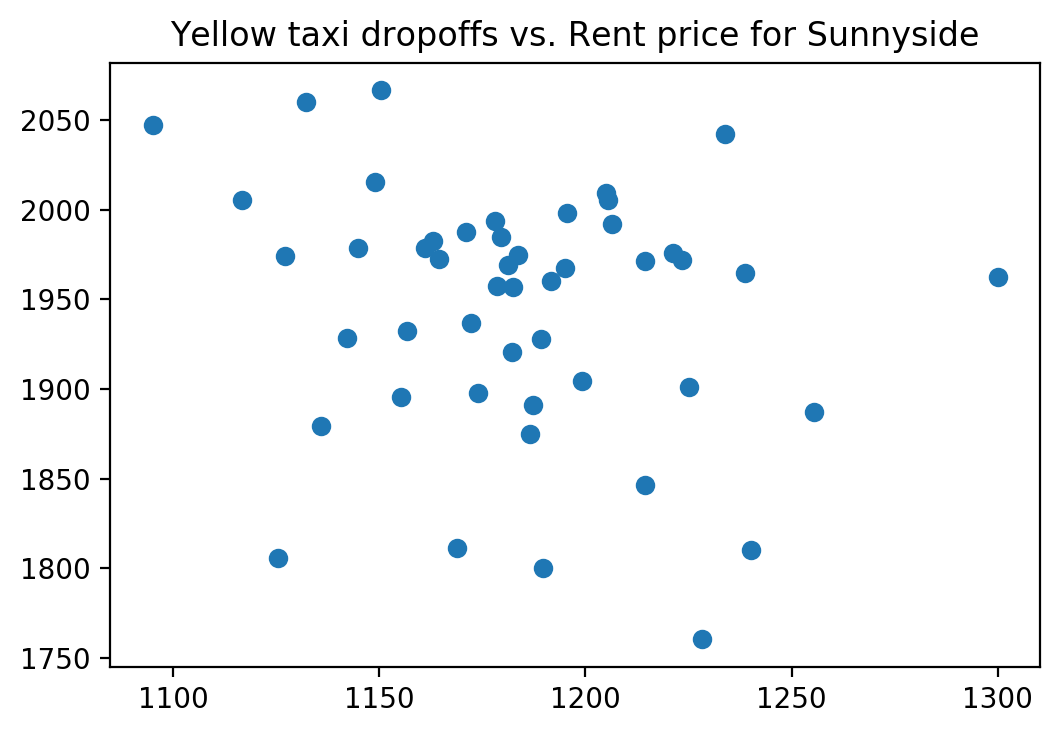

In [152]:
t_array = taxis.as_matrix()
z_array = rents.as_matrix()
print(t_array.shape)
print(z_array.shape)
plt.figure()
plt.scatter(t_array, z_array)
plt.title('Yellow taxi dropoffs vs. Rent price for ' + name)
plt.show()